# 1. Load Library

In this section we import all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import random
import pickle

from scipy.sparse import csr_matrix, vstack
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from xgboost import XGBRegressor                  # XGBoost for GPU processing
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay   # Classification metrics

print('Libraries loaded successfully')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/UCL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully


# 2. Load Dataset

Load the dataset (e.g., a CSV file) and preview it.

In [2]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    files = os.listdir(path)
    csv_path = os.path.join(path, 'GDSC_Cleaned.csv')
    df = pd.read_csv(csv_path)
    df.head()
else:
    path = current_path
    with open(os.path.join(path, 'GDSC_Cleaned.pkl'), 'rb') as f:
        df = pickle.load(f)

print("Path to dataset files:", path)

Path to dataset files: /Users/shijie/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


In [3]:
df.head()

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.592660,-1.516647,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.734047,-0.807232,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.582439,-1.570016,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [4]:
# check all columns unique values length
def check_unique_values(df):
    for col in df.columns:
        unique_values = df[col].nunique()
        print(f"Column '{col}' has {unique_values} unique values.")
check_unique_values(df)



Column 'COSMIC_ID' has 969 unique values.
Column 'CELL_LINE_NAME' has 969 unique values.
Column 'TCGA_DESC' has 32 unique values.
Column 'DRUG_ID' has 257 unique values.
Column 'DRUG_NAME' has 249 unique values.
Column 'LN_IC50' has 200401 unique values.
Column 'AUC' has 133567 unique values.
Column 'Z_SCORE' has 208199 unique values.
Column 'GDSC Tissue descriptor 1' has 19 unique values.
Column 'GDSC Tissue descriptor 2' has 54 unique values.
Column 'Cancer Type (matching TCGA label)' has 31 unique values.
Column 'Microsatellite instability Status (MSI)' has 2 unique values.
Column 'Screen Medium' has 2 unique values.
Column 'Growth Properties' has 3 unique values.
Column 'CNA' has 2 unique values.
Column 'Gene Expression' has 2 unique values.
Column 'Methylation' has 2 unique values.
Column 'TARGET' has 185 unique values.
Column 'TARGET_PATHWAY' has 24 unique values.


In [5]:
# Data preprocessing
categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)']
full_features = categorical_features + ['Microsatellite instability Status (MSI)', 'CNA', 'Gene Expression', 'Methylation']

data = df.copy()
# Filter highly skewed drugs: skewness of LN_IC50 should be ≤ 2
drug_skew = data.groupby("DRUG_NAME")["LN_IC50"].skew()
abs_skews = drug_skew.abs()
threshold = 2
low_skew_drugs = abs_skews[abs_skews <= threshold].index
data_filtered = data[data["DRUG_NAME"].isin(low_skew_drugs)].copy()
print(f"Using absolute skewness ≤ {threshold:.2f} as low‑skew cutoff.")
all_drugs = data["DRUG_NAME"].unique()
print(f"Filter {len(all_drugs) - len(low_skew_drugs)} drugs.")

# Could be adjusted to use all features
# data_filtered = data_filtered[data_filtered['DRUG_ID'] == 1003]
# data_filtered = data_filtered[data_filtered['DRUG_ID'].isin([1003, 1004, 1005, 1006, 1007])]
# data_filtered = data_filtered.drop(columns=['TARGET', 'TARGET_PATHWAY'])

# Drop rows with TARGET_PATHWAY=other or other, kinase
data_filtered = data_filtered[~data_filtered['TARGET_PATHWAY'].isin(['Other', 'Other, kinases'])]

X = data_filtered[full_features]
# X = data_filtered[categorical_features]

# One-Hot Encoding for X
X_encoder = OneHotEncoder(sparse_output=True)
X_encoded = X_encoder.fit_transform(X)
# X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data_filtered["LN_IC50"]
print(y.value_counts())

Using absolute skewness ≤ 2.00 as low‑skew cutoff.
Filter 6 drugs.
LN_IC50
-3.452815    5763
 9.622963      24
 5.063109       8
 6.417191       8
 4.976861       8
             ... 
 5.047957       1
 4.725636       1
 2.888847       1
 2.868932       1
 8.259562       1
Name: count, Length: 164234, dtype: int64


# 3. Cluster

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


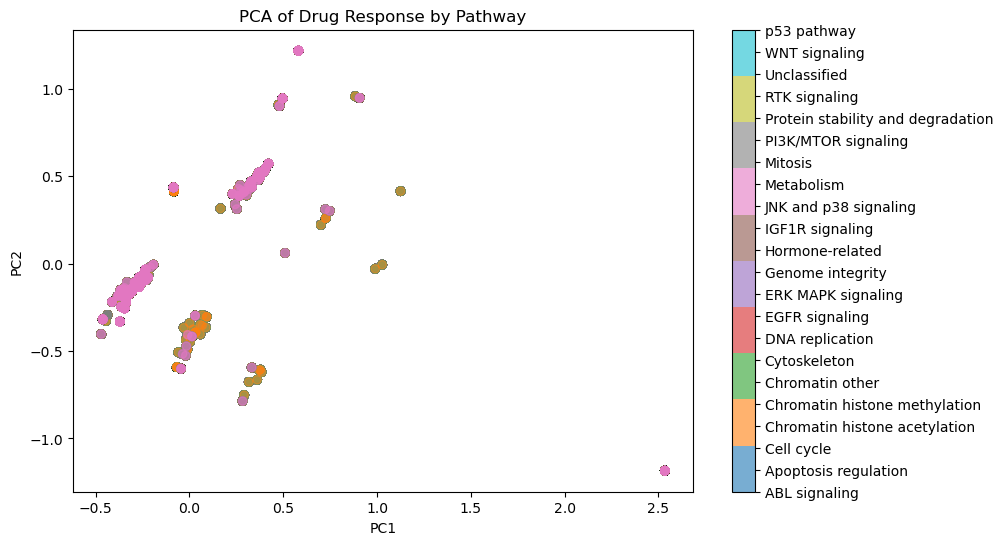

In [6]:
# cluster the targets without IDs by k-means

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded.toarray())
# Create a DataFrame with PCA results
pathway_cat = pd.Categorical(data_filtered['TARGET_PATHWAY'])
pca_df = pd.DataFrame(
    X_pca, 
    columns=['PC1','PC2'], 
    index=data_filtered.index
)
pca_df['ClusterCode'] = pathway_cat.codes  # 0,1,2,...
# Plot PCA results
# 3. 画散点，用整数 code 着色
plt.figure(figsize=(10,6))
sc = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=pca_df['ClusterCode'], 
    cmap='tab10',      # 离散色盘；也可以用 'viridis' 等
    alpha=0.6
)

# 4. colorbar 上打上每个 code 对应的 pathway 名称
cbar = plt.colorbar(sc, ticks=range(len(pathway_cat.categories)))
cbar.ax.set_yticklabels(pathway_cat.categories)

plt.title('PCA of Drug Response by Pathway')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [7]:
df['TARGET_PATHWAY'].value_counts()

TARGET_PATHWAY
PI3K/MTOR signaling                  22724
Other                                20659
Other, kinases                       17277
DNA replication                      16216
ERK MAPK signaling                   13350
Genome integrity                     12221
Cell cycle                           11620
Apoptosis regulation                 10828
Chromatin histone methylation        10612
RTK signaling                        10573
Chromatin histone acetylation         8162
Chromatin other                       7859
WNT signaling                         7631
Protein stability and degradation     7087
EGFR signaling                        6734
Mitosis                               6453
IGF1R signaling                       5512
Metabolism                            4802
Hormone-related                       3820
p53 pathway                           3776
Cytoskeleton                          3387
JNK and p38 signaling                 1905
ABL signaling                          

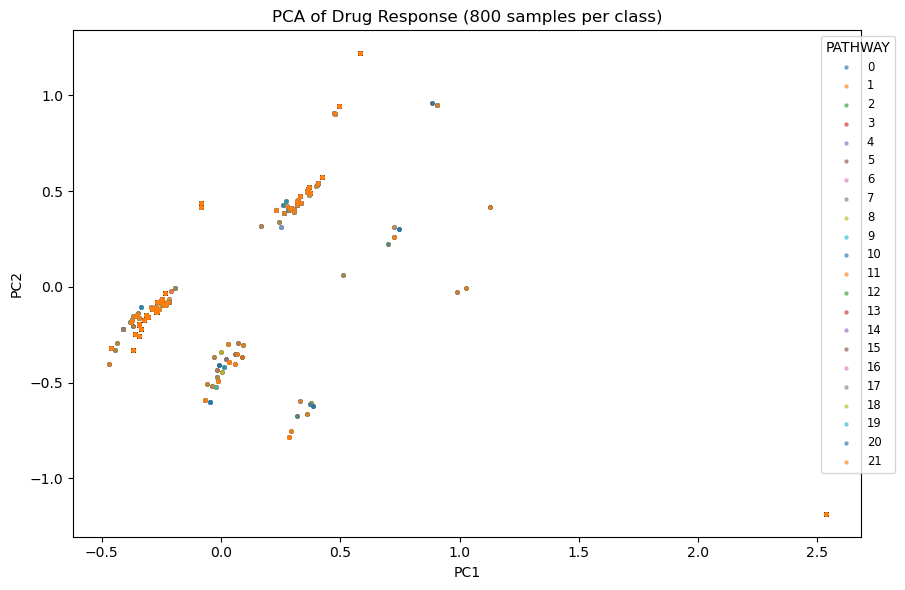

In [8]:
# 假设 pca_df 已经包含 PC1, PC2, Cluster 三列
total_samples = 20000
n_classes     = pca_df['ClusterCode'].nunique()
n_each        = total_samples // n_classes  # = 800

# 分层抽样
sampled = (
    pca_df
    .groupby('ClusterCode', group_keys=False)
    .apply(lambda grp: grp.sample(n=min(len(grp), n_each), random_state=42))
)

# 可视化
plt.figure(figsize=(10,6))
for label, sub in sampled.groupby('ClusterCode'):
    plt.scatter(
        sub['PC1'], sub['PC2'],
        s=5, alpha=0.5,
        label=label
    )
plt.legend(title='PATHWAY', bbox_to_anchor=(1.05,1), ncol=1, fontsize='small')
plt.title('PCA of Drug Response (800 samples per class)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/UCL/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Silhouette Score: 0.56


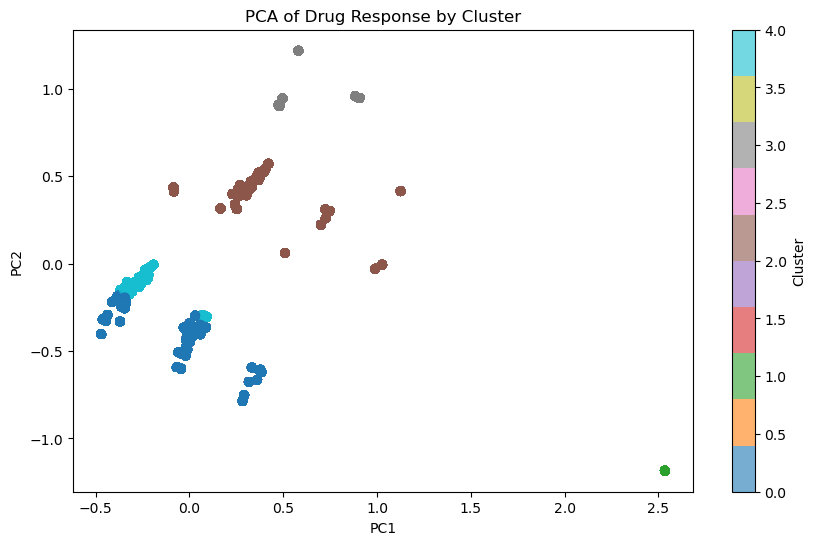

In [9]:
# k-means clustering based on PCA
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 5
# Create a KMeans instance with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Fit the KMeans model to the data
kmeans.fit(X_pca)
# Get the cluster labels
cluster_labels = kmeans.labels_
# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")
# Add cluster labels to the original DataFrame
data_filtered['Cluster'] = cluster_labels
# Plot PCA results with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=data_filtered['Cluster'], 
    cmap='tab10', 
    alpha=0.6
)
plt.title('PCA of Drug Response by Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
X_encoder.get_feature_names_out()  

array(['GDSC Tissue descriptor 1_aero_dig_tract',
       'GDSC Tissue descriptor 1_bone', 'GDSC Tissue descriptor 1_breast',
       'GDSC Tissue descriptor 1_digestive_system',
       'GDSC Tissue descriptor 1_kidney',
       'GDSC Tissue descriptor 1_large_intestine',
       'GDSC Tissue descriptor 1_leukemia',
       'GDSC Tissue descriptor 1_lung',
       'GDSC Tissue descriptor 1_lung_NSCLC',
       'GDSC Tissue descriptor 1_lung_SCLC',
       'GDSC Tissue descriptor 1_lymphoma',
       'GDSC Tissue descriptor 1_myeloma',
       'GDSC Tissue descriptor 1_nervous_system',
       'GDSC Tissue descriptor 1_neuroblastoma',
       'GDSC Tissue descriptor 1_pancreas',
       'GDSC Tissue descriptor 1_skin',
       'GDSC Tissue descriptor 1_soft_tissue',
       'GDSC Tissue descriptor 1_thyroid',
       'GDSC Tissue descriptor 1_urogenital_system',
       'GDSC Tissue descriptor 1_nan',
       'GDSC Tissue descriptor 2_B_cell_leukemia',
       'GDSC Tissue descriptor 2_B_cell_lymphoma',
 

In [12]:
import prince
import pandas as pd
import matplotlib.pyplot as plt

# 假设data_filtered是你的原始DataFrame，所有特征为分类变量
# 注意：这里不需要先进行one-hot encoding

# 实施MCA
mca = prince.MCA(n_components=2, random_state=42)
mca_result = mca.fit_transform(X)

# 获取pathway类别编码，用于可视化
pathway_cat = pd.Categorical(data_filtered['TARGET_PATHWAY'])

# 构建结果DataFrame
mca_df = pd.DataFrame(
    mca_result,
    columns=['Dim1', 'Dim2'],
    index=data_filtered.index
)
mca_df['ClusterCode'] = pathway_cat.codes

# 绘制MCA结果散点图
plt.figure(figsize=(10,6))
sc = plt.scatter(
    mca_df['Dim1'],
    mca_df['Dim2'],
    c=mca_df['ClusterCode'],
    cmap='tab10',
    alpha=0.6
)

# 添加colorbar显示每个类别名称
cbar = plt.colorbar(sc, ticks=range(len(pathway_cat.categories)))
cbar.ax.set_yticklabels(pathway_cat.categories)

plt.title('MCA of Drug Response by Pathway')
plt.xlabel('MCA Dimension 1')
plt.ylabel('MCA Dimension 2')
plt.show()


ModuleNotFoundError: No module named 'prince'